In [1]:
import simpy
import numpy as np

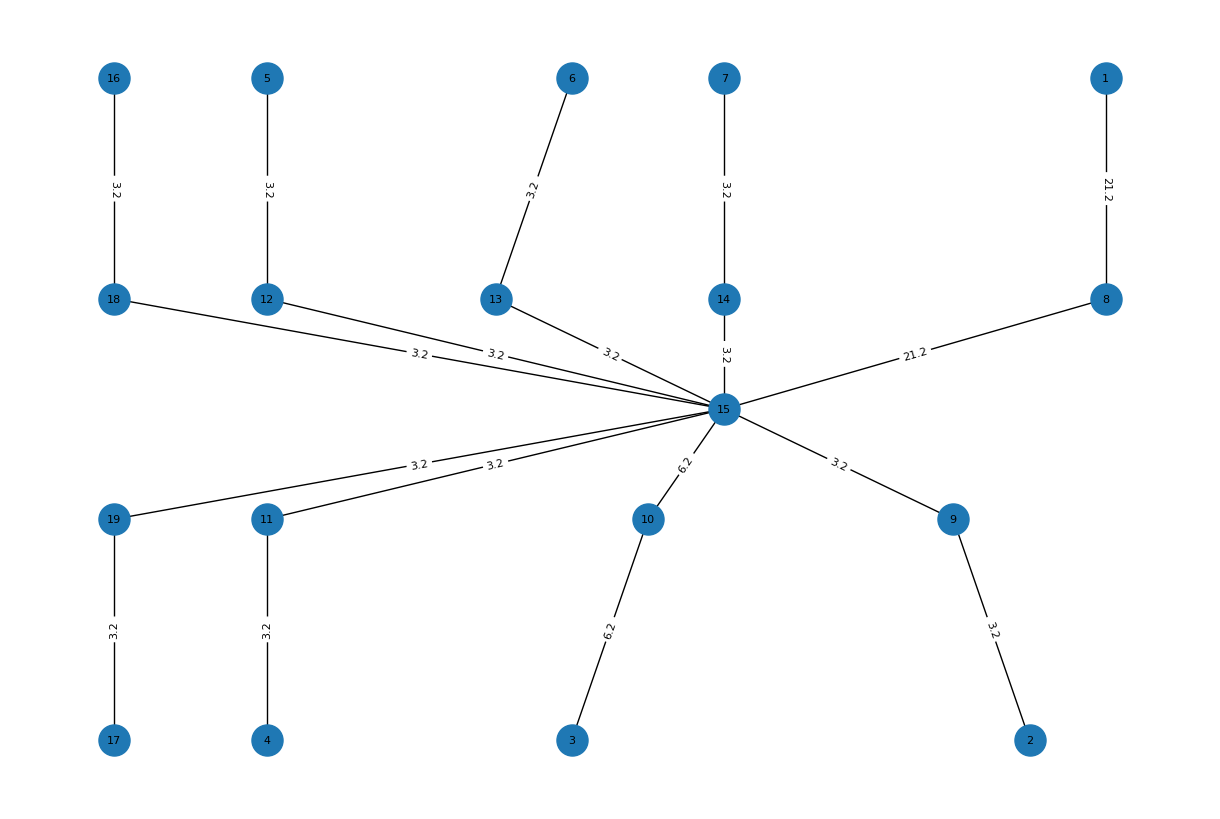

Paths for Each Trip:
From triage to Reception: ['triage', 'd1', 'corridor', 'd2', 'Reception']
From triage to waiting: ['triage', 'd1', 'corridor', 'd3', 'waiting']
From triage to pharmacy: ['triage', 'd1', 'corridor', 'd4', 'pharmacy']
From triage to ER_3: ['triage', 'd1', 'corridor', 'd5', 'ER_3']
From triage to ER_2: ['triage', 'd1', 'corridor', 'd6', 'ER_2']
From triage to ER_1: ['triage', 'd1', 'corridor', 'd7', 'ER_1']
From triage to corridor: ['triage', 'd1', 'corridor']
From triage to imaging: ['triage', 'd1', 'corridor', 'd8', 'imaging']
From triage to lab: ['triage', 'd1', 'corridor', 'd9', 'lab']
From Reception to triage: ['Reception', 'd2', 'corridor', 'd1', 'triage']
From Reception to waiting: ['Reception', 'd2', 'corridor', 'd3', 'waiting']
From Reception to pharmacy: ['Reception', 'd2', 'corridor', 'd4', 'pharmacy']
From Reception to ER_3: ['Reception', 'd2', 'corridor', 'd5', 'ER_3']
From Reception to ER_2: ['Reception', 'd2', 'corridor', 'd6', 'ER_2']
From Reception to

In [2]:
# 3. display the paths for each trip

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define the Graph
G = nx.Graph()
G.add_node(1, name="triage", pos=(12, 4, 0), area=20)
G.add_node(2, name="Reception", pos=(11, 1, 0), area=20)
G.add_node(3, name="waiting", pos=(5, 1, 0), area=30)
G.add_node(4, name="pharmacy", pos=(1, 1, 0), area=20)
G.add_node(5, name="ER_3", pos=(1, 4, 0), area=15)
G.add_node(6, name="ER_2", pos=(5, 4, 0), area=15)
G.add_node(7, name="ER_1", pos=(7, 4, 0), area=15)
G.add_node(15, name="corridor", pos=(7, 2.5, 0), area=30)
G.add_node(16, name="imaging", pos=(-1, 4, 0), area=20)
G.add_node(17, name="lab", pos=(-1, 1, 0), area=20)

G.add_node(8, name="d1", pos=(12, 3, 0), area='NA')
G.add_node(9, name="d2", pos=(10, 2, 0), area='NA')
G.add_node(10, name="d3", pos=(6, 2, 0), area='NA')
G.add_node(11, name="d4", pos=(1, 2, 0), area='NA')
G.add_node(12, name="d5", pos=(1, 3, 0), area='NA')
G.add_node(13, name="d6", pos=(4, 3, 0), area='NA')
G.add_node(14, name="d7", pos=(7, 3, 0), area='NA')
G.add_node(18, name="d8", pos=(-1, 3, 0), area='NA')
G.add_node(19, name="d9", pos=(-1, 2, 0), area='NA')

G.add_edges_from([
    (1, 8), (8, 15), (9, 15), (2, 9), (7, 14), 
    (14, 15), (10, 15), (3, 10), (6, 13), 
    (13, 15), (11, 15), (4, 11), (5, 12), (12, 15),
    (16, 18), (17, 19), (15, 18), (15, 19)
])

# Step 2: Calculate Room Capacity Based on Space Requirement
space_requirements = {"triage": 2, "ER": 2}  # Space requirement in m² per person
default_space_requirement = 15  # Default space for all other rooms

node_areas = nx.get_node_attributes(G, 'area')
node_names = nx.get_node_attributes(G, 'name')

trip_generation = {}
trip_attraction = {}

for node, area in node_areas.items():
    if isinstance(area, (int, float)):
        # Determine space requirement based on node name
        if any(key in node_names[node].lower() for key in space_requirements):
            space_requirement = space_requirements["triage"]  # 2 m² per person for "triage" or "ER"
        else:
            space_requirement = default_space_requirement  # 15 m² per person for other rooms
        
        # Calculate room capacity
        capacity = area // space_requirement
        trip_generation[node] = int(capacity)
        trip_attraction[node] = int(capacity)
    else:
        # No generation/attraction for undefined areas
        trip_generation[node] = 0
        trip_attraction[node] = 0

# Step 3: Compute Distance Matrix
distance_matrix = {}
for n1 in G.nodes:
    distance_matrix[n1] = {}
    for n2 in G.nodes:
        if nx.has_path(G, n1, n2):
            distance_matrix[n1][n2] = nx.shortest_path_length(G, source=n1, target=n2)
        else:
            distance_matrix[n1][n2] = float('inf')

# Step 4: Trip Distribution Using Gravity Model
T = {}
for i in G.nodes:
    T[i] = {}
    for j in G.nodes:
        if i != j and distance_matrix[i][j] > 0:
            T[i][j] = trip_generation[i] * trip_attraction[j] / distance_matrix[i][j] ** 2
        else:
            T[i][j] = 0

# Step 5: Trip Assignment (Shortest Path Allocation with Path Collection)
flows = {tuple(sorted(edge)): 0 for edge in G.edges}
paths = {}  # To store paths for each trip
total_trips = 0  # Initialize total trips counter

for origin in G.nodes:
    for destination in G.nodes:
        if origin != destination and T[origin][destination] > 0:
            total_trips += T[origin][destination]  # Add trips to the total
            path = nx.shortest_path(G, source=origin, target=destination)
            paths[(origin, destination)] = path  # Store the path
            for i in range(len(path) - 1):
                edge = tuple(sorted((path[i], path[i + 1])))
                flows[edge] += T[origin][destination]

# Step 6: Visualization
edge_labels = {edge: round(flow, 1) for edge, flow in flows.items()}
node_labels = nx.get_node_attributes(G, 'name')

plt.figure(figsize=(12, 8))
pos = {node: (attr[0], attr[1]) for node, attr in nx.get_node_attributes(G, 'pos').items()}
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.show()

# Print paths for each trip
print("Paths for Each Trip:")
for (origin, destination), path in paths.items():
    origin_name = node_names[origin]
    destination_name = node_names[destination]
    path_names = [node_names[node] for node in path]
    print(f"From {origin_name} to {destination_name}: {path_names}")

# Print trip generation and attraction for reference
print(paths)
print("\nTrip Generation:", trip_generation)
print("Trip Attraction:", trip_attraction)
print(f"\nTotal Trips: {round(total_trips, 1)}")
print(sum(trip_generation.values()))

In [3]:
env = simpy.Environment()

In [4]:
# Create SimPy resources for rooms
room_resources = {}
for node, capacity in trip_attraction.items():
    if capacity > 0:
        room_resources[node] = simpy.Resource(env, capacity=int(capacity))


In [5]:
def patient(env, patient_id, origin, destination, path, room_resources, G):
    arrival_time = env.now
    total_waiting_time = 0
    total_walking_distance = 0
    current_node = origin

    for i in range(len(path) - 1):
        next_node = path[i + 1]
        # Calculate walking distance and time
        walking_distance = nx.shortest_path_length(G, source=current_node, target=next_node)
        walking_speed = 40  # Units per time unit (adjust as needed)
        walking_time = walking_distance / walking_speed
        yield env.timeout(walking_time)
        total_walking_distance += walking_distance

        # If the next node is a room with capacity constraints
        if next_node in room_resources:
            with room_resources[next_node].request() as request:
                arrival_to_room = env.now
                yield request  # Wait until room is available
                waiting_time = env.now - arrival_to_room
                total_waiting_time += waiting_time
                # Simulate service time in room
                service_time = 5  # Time spent in the room (adjust as needed)
                
                yield env.timeout(np.random.exponential(service_time))
        current_node = next_node

    # Collect patient data
    patient_data.append({
        'patient_id': patient_id,
        'arrival_time': arrival_time,
        'departure_time': env.now,
        'total_walking_distance': total_walking_distance,
        'total_waiting_time': total_waiting_time,
        'origin': origin,
        'destination': destination
    })


In [6]:
patient_data = []

def patient_generator(env, trip_generation, T, paths, room_resources, G):
    patient_id = 0
    for origin in G.nodes:
        num_patients = trip_generation[origin]
        for _ in range(num_patients):
            for destination in G.nodes:
                if origin != destination and T[origin][destination] > 0:
                    num_trips = int(T[origin][destination])
                    for _ in range(num_trips):
                        path = paths.get((origin, destination))
                        if path:
                            env.process(patient(env, patient_id, origin, destination, path, room_resources, G))
                            patient_id += 1
                            inter_arrival_time = 5  # Time between patient arrivals (adjust as needed) #这里
                            yield env.timeout(np.random.exponential(inter_arrival_time))


In [7]:
# Initialize data structures
room_occupancy = {node: [] for node in room_resources}

def occupancy_monitor(env, room_resources):
    while True:
        for node, resource in room_resources.items():
            occupancy = len(resource.users)
            room_occupancy[node].append((env.now, occupancy))
        yield env.timeout(1)  # Record every time unit

# Start occupancy monitoring
env.process(occupancy_monitor(env, room_resources))

<Process(occupancy_monitor) object at 0x273766a6dd0>

In [8]:
# Start patient generation
env.process(patient_generator(env, trip_generation, T, paths, room_resources, G))

# Run the simulation
simulation_time = 1000  # Total simulation time (adjust as needed)
env.run(until=simulation_time)

In [9]:
# Compute average walking distance
if patient_data:
    average_walking_distance = sum(p['total_walking_distance'] for p in patient_data) / len(patient_data)
else:
    average_walking_distance = 0

# Compute average waiting time
if patient_data:
    average_waiting_time = sum(p['total_waiting_time'] for p in patient_data) / len(patient_data)
else:
    average_waiting_time = 0

print(f"Average Walking Distance: {average_walking_distance}")
print(f"Average Waiting Time: {average_waiting_time}")
print(patient_data)

Average Walking Distance: 2.3157894736842106
Average Waiting Time: 0.4054920059911233
[{'patient_id': 0, 'arrival_time': 0, 'departure_time': 5.801759325416841, 'total_walking_distance': 4, 'total_waiting_time': 0.0, 'origin': 1, 'destination': 3}, {'patient_id': 1, 'arrival_time': 11.845273525597506, 'departure_time': 13.010769395702091, 'total_walking_distance': 2, 'total_waiting_time': 0.0, 'origin': 1, 'destination': 15}, {'patient_id': 2, 'arrival_time': 18.216827422644194, 'departure_time': 21.13075400860137, 'total_walking_distance': 2, 'total_waiting_time': 0.0, 'origin': 1, 'destination': 15}, {'patient_id': 3, 'arrival_time': 24.84146275144493, 'departure_time': 25.396781233341514, 'total_walking_distance': 2, 'total_waiting_time': 0.0, 'origin': 1, 'destination': 15}, {'patient_id': 5, 'arrival_time': 38.537903698012116, 'departure_time': 44.08924576370811, 'total_walking_distance': 2, 'total_waiting_time': 0.0, 'origin': 1, 'destination': 15}, {'patient_id': 6, 'arrival_tim

In [10]:
# Calculate average density
average_density = {}
for node, occupancy_data in room_occupancy.items():
    if occupancy_data:
        total_occupancy = sum(occupancy for time, occupancy in occupancy_data)
        average_occupancy = total_occupancy / len(occupancy_data)
        average_density[node] = average_occupancy
    else:
        average_density[node] = 0

print("\nAverage People Density:")
for node, density in average_density.items():
    room_name = node_names[node]
    print(f"{room_name}: {density}")

print(average_density)


Average People Density:
triage: 0.037
Reception: 0.0
waiting: 0.063
pharmacy: 0.0
ER_3: 0.0
ER_2: 0.0
ER_1: 0.0
corridor: 0.279
imaging: 0.0
lab: 0.0
{1: 0.037, 2: 0.0, 3: 0.063, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 15: 0.279, 16: 0.0, 17: 0.0}
